**MahaswetaKundu-Data Science Assignment Instructions –
Web3 Trading Team**

Importing neccessary libraryies

In [1]:
import os, pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

Mount Drive & create the required project folders


In [2]:
from google.colab import drive
drive.mount('/content/drive')

PROJECT_ROOT = '/content/drive/MyDrive/ds_MahaswetaKundu'

# Standardized submission structure
import os
os.makedirs(f'{PROJECT_ROOT}/csv_files', exist_ok=True)
os.makedirs(f'{PROJECT_ROOT}/outputs', exist_ok=True)

print('Project root:', PROJECT_ROOT)
!ls -R "$PROJECT_ROOT"


Mounted at /content/drive
Project root: /content/drive/MyDrive/ds_MahaswetaKundu
/content/drive/MyDrive/ds_MahaswetaKundu:
csv_files  outputs

/content/drive/MyDrive/ds_MahaswetaKundu/csv_files:
by_classification_summary.csv  reg_pnl_classlag5.csv
coin_summary.csv	       reg_pnl_value_lag1.csv
correlation_table.csv	       reg_pnl_value_lag3.csv
daily_aggregates.csv	       reg_pnl_value_lag5.csv
daily_stats.csv		       regression_coefficients.csv
daily_with_sentiment.csv       risk_summary.csv
fear_greed_index.csv	       sentiment_group_comparison.csv
historical_data.csv	       top5_days.csv
reg_pnl_classlag1.csv	       worst5_days.csv
reg_pnl_classlag3.csv

/content/drive/MyDrive/ds_MahaswetaKundu/outputs:
bar_mean_pnl_by_bucket.png     daily_pnl_timeseries.png
bar_mean_pnl_by_sentiment.png  drawdown.png
bar_tradecount_by_bucket.png   rolling_vol_21d.png
bar_winrate_by_bucket.png      scatter_leverage_vs_pnl.png
boxplot_pnl_by_sentiment.png   scatter_volume_vs_pnl.png
cum_pnl.png


Load data + helper savers

In [3]:
CSV_DIR = f'{PROJECT_ROOT}/csv_files'
OUT_DIR = f'{PROJECT_ROOT}/outputs'

def save_df(df, name):
    path = os.path.join(CSV_DIR, name)
    df.to_csv(path, index=False)
    print(f"Saved: {path}")

def save_fig(fname):
    path = os.path.join(OUT_DIR, fname)
    plt.tight_layout()
    plt.savefig(path, dpi=150)
    print(f"Saved: {path}")

trades = pd.read_csv(f'{CSV_DIR}/historical_data.csv', low_memory=False)
sentiment = pd.read_csv(f'{CSV_DIR}/fear_greed_index.csv', low_memory=False)

print('Trades shape:', trades.shape)
print('Sentiment shape:', sentiment.shape)
trades.head(3), sentiment.head(3)


Trades shape: (211224, 16)
Sentiment shape: (2644, 4)


(                                      Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
 
    Closed PnL                                   Transaction Hash     Order ID  \
 0         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   
 1         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   
 2         0.0  0xec09451986a1874e3a980418412fcd0201f500c95bac...  52017706630   
 
    Crossed       Fee      Trade ID     Timestamp  
 0     Tru

Clean & engineer features

In [4]:
# Parse time and get date for daily grouping
trades['Timestamp IST'] = pd.to_datetime(trades['Timestamp IST'], format='%d-%m-%Y %H:%M', errors='coerce')
trades['date'] = trades['Timestamp IST'].dt.date

# Win flag (realized PnL > 0)
trades['win_flag'] = (trades['Closed PnL'] > 0).astype(int)

# Daily aggregation
daily = trades.groupby('date').agg(
    daily_pnl=('Closed PnL', 'sum'),
    daily_volume=('Size USD', 'sum'),
    trade_count=('Trade ID', 'count'),
    win_rate=('win_flag', 'mean')
).reset_index()

# Sentiment date alignment
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

# Merge daily stats with sentiment
daily_with_sent = pd.merge(daily, sentiment[['date','value','classification']], on='date', how='left')

save_df(daily, 'daily_stats.csv')
save_df(daily_with_sent, 'daily_with_sentiment.csv')

daily_with_sent.head()


Saved: /content/drive/MyDrive/ds_MahaswetaKundu/csv_files/daily_stats.csv
Saved: /content/drive/MyDrive/ds_MahaswetaKundu/csv_files/daily_with_sentiment.csv


,date,daily_pnl,daily_volume,trade_count,win_rate,value,classification
0,2023-05-01,0.000000,477.00,3,0.000000,63.0,Greed
1,2023-12-05,0.000000,50005.83,9,0.000000,75.0,Extreme Greed
2,2023-12-14,-205.434737,113203.35,11,0.363636,72.0,Greed
3,2023-12-15,-24.632034,10609.95,2,0.000000,70.0,Greed
4,2023-12-16,0.000000,15348.77,3,0.000000,67.0,Greed


In [5]:
print('=== Trades info ==='); print(trades.info())
print('\n=== Daily stats (first 5) ==='); print(daily.head())
print('\nMissing (daily_with_sent):'); print(daily_with_sent.isna().sum())


=== Trades info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Account           211224 non-null  object        
 1   Coin              211224 non-null  object        
 2   Execution Price   211224 non-null  float64       
 3   Size Tokens       211224 non-null  float64       
 4   Size USD          211224 non-null  float64       
 5   Side              211224 non-null  object        
 6   Timestamp IST     211224 non-null  datetime64[ns]
 7   Start Position    211224 non-null  float64       
 8   Direction         211224 non-null  object        
 9   Closed PnL        211224 non-null  float64       
 10  Transaction Hash  211224 non-null  object        
 11  Order ID          211224 non-null  int64         
 12  Crossed           211224 non-null  bool          
 13  Fee               211224 non-null  floa

Visualizations (saved to outputs/)

Saved: /content/drive/MyDrive/ds_MahaswetaKundu/outputs/daily_pnl_timeseries.png


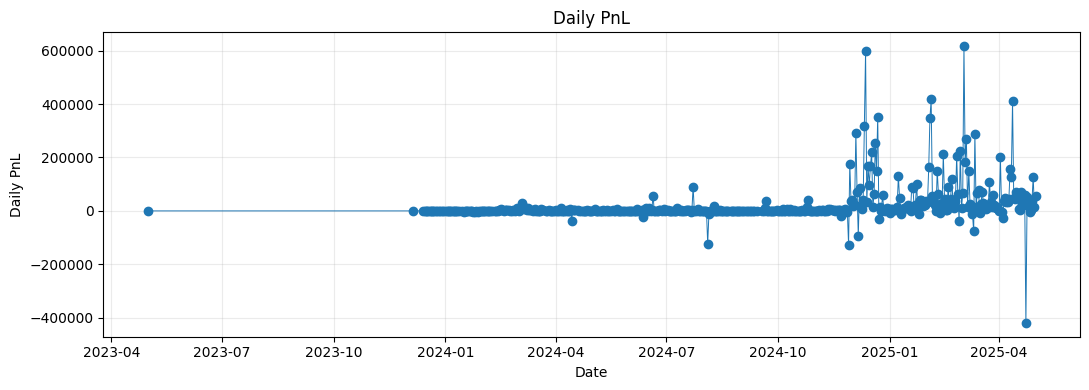

Saved: /content/drive/MyDrive/ds_MahaswetaKundu/outputs/boxplot_pnl_by_sentiment.png


<Figure size 640x480 with 0 Axes>

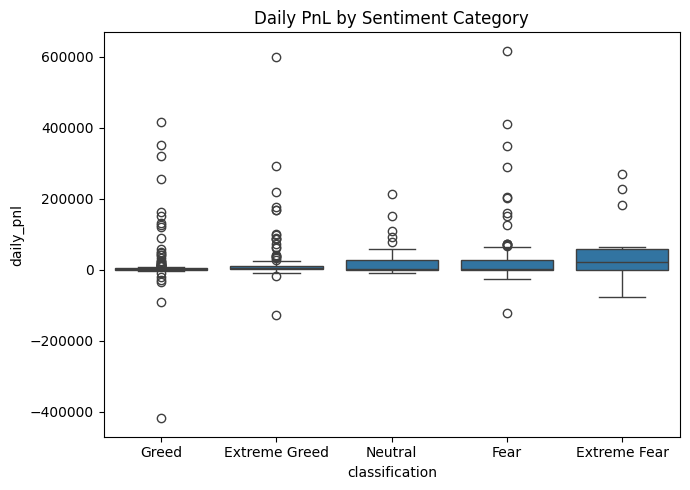

Saved: /content/drive/MyDrive/ds_MahaswetaKundu/outputs/scatter_volume_vs_pnl.png


<Figure size 640x480 with 0 Axes>

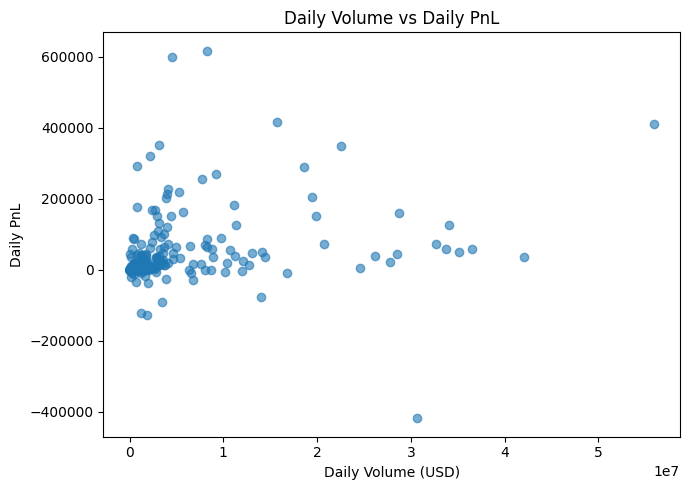

Saved: /content/drive/MyDrive/ds_MahaswetaKundu/outputs/bar_mean_pnl_by_sentiment.png


<Figure size 640x480 with 0 Axes>

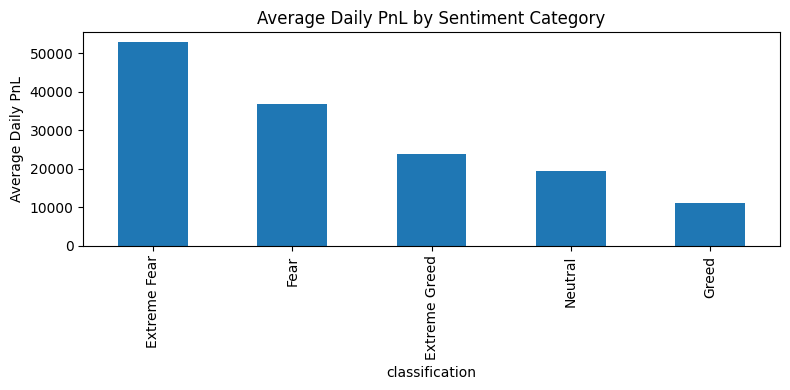

<Figure size 640x480 with 0 Axes>

In [6]:
# 5a) Daily PnL time series
plt.figure(figsize=(11,4))
plt.plot(daily_with_sent['date'], daily_with_sent['daily_pnl'], marker='o', linewidth=0.7)
plt.title('Daily PnL'); plt.xlabel('Date'); plt.ylabel('Daily PnL'); plt.grid(alpha=0.25)
save_fig('daily_pnl_timeseries.png')
plt.show(); plt.clf()

# 5b) Boxplot of PnL by sentiment category (if available)
if daily_with_sent['classification'].notna().any():
    plt.figure(figsize=(7,5))
    sns.boxplot(data=daily_with_sent, x='classification', y='daily_pnl')
    plt.title('Daily PnL by Sentiment Category')
    save_fig('boxplot_pnl_by_sentiment.png')
    plt.show(); plt.clf()

# 5c) Volume vs PnL
plt.figure(figsize=(7,5))
plt.scatter(daily_with_sent['daily_volume'], daily_with_sent['daily_pnl'], alpha=0.6)
plt.xlabel('Daily Volume (USD)'); plt.ylabel('Daily PnL')
plt.title('Daily Volume vs Daily PnL')
save_fig('scatter_volume_vs_pnl.png')
plt.show(); plt.clf()

# 5d) Average PnL by classification (bar)
if daily_with_sent['classification'].notna().any():
    plt.figure(figsize=(8,4))
    (daily_with_sent
     .groupby('classification')['daily_pnl']
     .mean()
     .sort_values(ascending=False)
     .plot(kind='bar'))
    plt.title('Average Daily PnL by Sentiment Category')
    plt.ylabel('Average Daily PnL')
    save_fig('bar_mean_pnl_by_sentiment.png')
    plt.show(); plt.clf()


Correlations & summary tables

In [7]:
corr = daily_with_sent[['daily_pnl','daily_volume','trade_count','win_rate','value']].corr()
save_df(corr.reset_index().rename(columns={'index':'metric'}), 'correlation_table.csv')
corr


Saved: /content/drive/MyDrive/ds_MahaswetaKundu/csv_files/correlation_table.csv


,daily_pnl,daily_volume,trade_count,win_rate,value
daily_pnl,1.000000,0.325447,0.360083,0.170511,-0.082642
daily_volume,0.325447,1.000000,0.720238,0.046262,-0.264371
trade_count,0.360083,0.720238,1.000000,0.092548,-0.245241
win_rate,0.170511,0.046262,0.092548,1.000000,0.152485
value,-0.082642,-0.264371,-0.245241,0.152485,1.000000


In [8]:
# Grouped summary by sentiment
by_class = (daily_with_sent.groupby('classification')
            .agg(days=('date','count'),
                 mean_pnl=('daily_pnl','mean'),
                 median_pnl=('daily_pnl','median'),
                 win_rate=('win_rate','mean'),
                 trade_count=('trade_count','mean'),
                 volume=('daily_volume','mean'),
                 fgi=('value','mean'))
            .sort_values('mean_pnl', ascending=False))

save_df(by_class.reset_index(), 'by_classification_summary.csv')
by_class


Saved: /content/drive/MyDrive/ds_MahaswetaKundu/csv_files/by_classification_summary.csv


,days,mean_pnl,median_pnl,win_rate,trade_count,volume,fgi
classification,,,,,,,
Extreme Fear,14,52793.589178,22561.739636,0.327341,1528.571429,8.177447e+06,19.285714
Fear,91,36891.818040,1412.314654,0.329112,679.527473,5.311261e+06,32.263736
Extreme Greed,114,23817.292199,3127.536297,0.467424,350.807018,1.091800e+06,79.254386
Neutral,67,19297.323516,1818.573295,0.331886,562.477612,2.690180e+06,49.791045
Greed,193,11140.566181,678.475928,0.335986,260.637306,1.495246e+06,68.336788


Regression (impact on PnL)

In [9]:
d = daily_with_sent.copy()

# Make sure classification exists before creating dummies
if 'classification' in d.columns:
    d['classification_cat'] = d['classification'].astype('category')
    d = pd.get_dummies(d, columns=['classification_cat'], drop_first=True)

# y: dependent variable
y = pd.to_numeric(d['daily_pnl'], errors='coerce')

# X: independent variables
base_cols = ['trade_count', 'daily_volume', 'win_rate']
X = d[base_cols].apply(pd.to_numeric, errors='coerce')

# Add dummy columns if present
dummy_cols = [c for c in d.columns if c.startswith('classification_cat_')]
for c in dummy_cols:
    X[c] = pd.to_numeric(d[c], errors='coerce')

# Combine y and X into one DataFrame and drop any rows with NaN
reg_data = pd.concat([y, X], axis=1).dropna()

# Extract cleaned y and X as NumPy arrays
y_clean = reg_data['daily_pnl'].to_numpy(dtype=float)
X_clean = reg_data.drop(columns=['daily_pnl']).to_numpy(dtype=float)

# Add constant term
X_clean = sm.add_constant(X_clean)

# Run regression
model = sm.OLS(y_clean, X_clean).fit(cov_type='HC3')
print(model.summary())

# Save coefficients
coef_df = pd.DataFrame({
    'term': ['const'] + base_cols + dummy_cols,
    'coef': model.params,
    'p_value': model.pvalues
})
save_df(coef_df, 'regression_coefficients.csv')


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     3.276
Date:                Thu, 14 Aug 2025   Prob (F-statistic):            0.00363
Time:                        11:52:12   Log-Likelihood:                -6005.7
No. Observations:                 480   AIC:                         1.203e+04
Df Residuals:                     472   BIC:                         1.206e+04
Df Model:                           7                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4193.2472   3.34e+04     -0.126      0.9

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1894: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 7, but rank is 6
  warnings.warn('covariance of constraints does not have full '


Saved: /content/drive/MyDrive/ds_MahaswetaKundu/csv_files/regression_coefficients.csv


 Granger causality

In [10]:
d = daily_with_sent.sort_values('date').copy()
d['classification_code'] = pd.factorize(d['classification'])[0]
gc_df = d[['daily_volume','classification_code']].dropna()

if len(gc_df) > 8:   # a tiny guard for sample size
    res = grangercausalitytests(gc_df[['daily_volume','classification_code']], maxlag=1, verbose=False)
    print("Granger causality ran (lag=1). Check stats in 'res'.")
else:
    print("Not enough observations for Granger test.")


Granger causality ran (lag=1). Check stats in 'res'.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/stattools.py:1556: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


Top/worst days and top coins


In [11]:
top_days = daily_with_sent.sort_values('daily_pnl', ascending=False).head(5)[['date','daily_pnl']]
worst_days = daily_with_sent.sort_values('daily_pnl', ascending=True).head(5)[['date','daily_pnl']]
save_df(top_days, 'top5_days.csv')
save_df(worst_days, 'worst5_days.csv')
print(top_days); print(worst_days)

# Per-coin summary
coin_summary = (trades.groupby('Coin')
                .agg(total_pnl=('Closed PnL','sum'),
                     total_volume=('Size USD','sum'),
                     trades=('Trade ID','count'))
                .sort_values('total_pnl', ascending=False))
save_df(coin_summary.reset_index(), 'coin_summary.csv')
coin_summary.head(10)


Saved: /content/drive/MyDrive/ds_MahaswetaKundu/csv_files/top5_days.csv
Saved: /content/drive/MyDrive/ds_MahaswetaKundu/csv_files/worst5_days.csv
           date      daily_pnl
420  2025-03-03  616413.032233
339  2024-12-12  599151.795008
393  2025-02-04  416876.888120
460  2025-04-12  410419.694533
349  2024-12-22  352197.163973
           date      daily_pnl
471  2025-04-23 -419020.225731
325  2024-11-28 -127075.399585
219  2024-08-04 -122672.000883
333  2024-12-06  -92624.643895
428  2025-03-11  -76880.729036
Saved: /content/drive/MyDrive/ds_MahaswetaKundu/csv_files/coin_summary.csv


,total_pnl,total_volume,trades
Coin,,,
@107,2.783913e+06,5.576086e+07,29992
HYPE,1.948485e+06,1.419902e+08,68005
SOL,1.639556e+06,1.250748e+08,10691
ETH,1.319979e+06,1.182810e+08,11158
BTC,8.680447e+05,6.442321e+08,26064
MELANIA,3.903511e+05,7.040710e+06,4428
ENA,2.173295e+05,1.625400e+06,990
SUI,1.992688e+05,7.781168e+06,1979
ZRO,1.837778e+05,1.213825e+06,1239


Risk metrics (volatility, drawdown, streaks, VaR)

Saved: /content/drive/MyDrive/ds_MahaswetaKundu/csv_files/risk_summary.csv
Saved: /content/drive/MyDrive/ds_MahaswetaKundu/outputs/cum_pnl.png


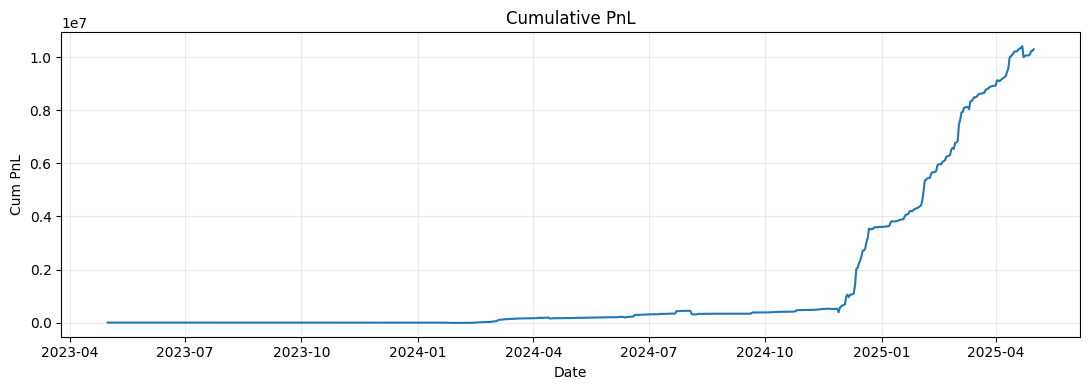

Saved: /content/drive/MyDrive/ds_MahaswetaKundu/outputs/drawdown.png


<Figure size 640x480 with 0 Axes>

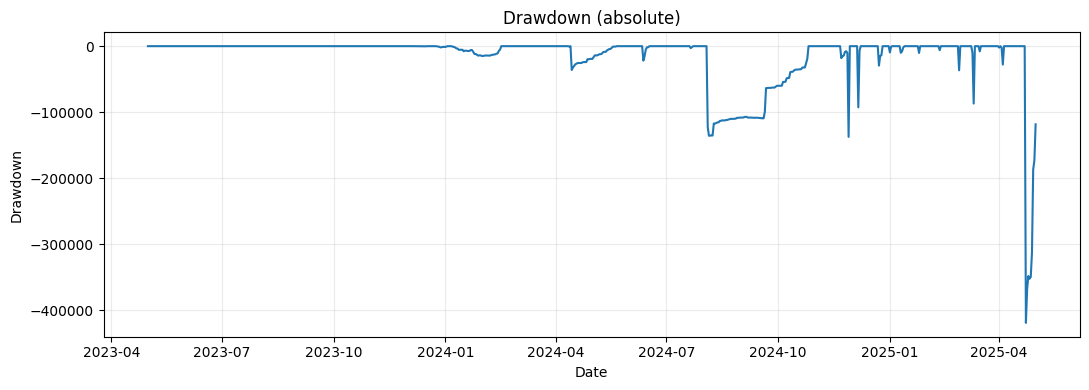

Saved: /content/drive/MyDrive/ds_MahaswetaKundu/outputs/rolling_vol_21d.png


<Figure size 640x480 with 0 Axes>

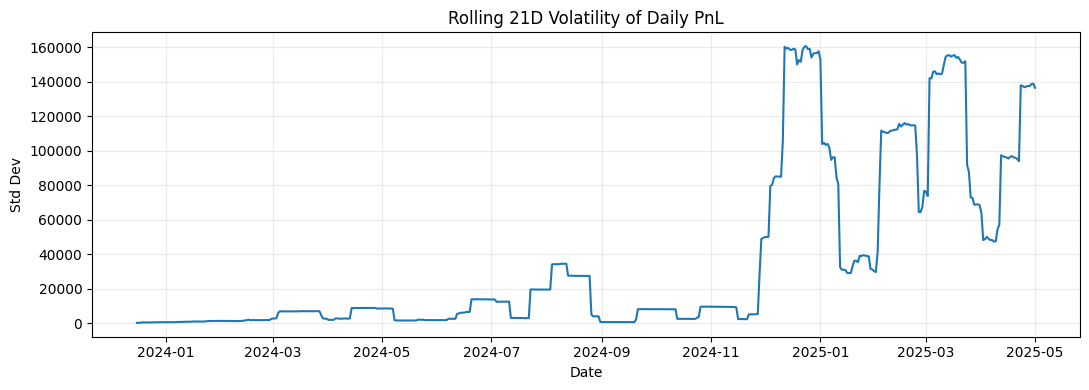

Risk summary:
                 metric          value
0         max_drawdown -419020.225731
1     max_drawdown_pct      -3.937419
2   longest_win_streak      19.000000
3  longest_loss_streak       6.000000
4               VaR_95   -2371.566698


<Figure size 640x480 with 0 Axes>

In [12]:
# Ensure sorted by date
dw = daily_with_sent.sort_values('date').copy()

# --- Rolling risk ---
# 21-trading-day (~1 month) rolling volatility of daily PnL
dw['pnl_rolling_std_21'] = pd.Series(dw['daily_pnl']).rolling(21, min_periods=5).std()

# --- Cumulative PnL & drawdowns ---
dw['cum_pnl'] = dw['daily_pnl'].cumsum()
roll_max = dw['cum_pnl'].cummax()
dw['drawdown'] = dw['cum_pnl'] - roll_max
dw['drawdown_pct'] = dw['cum_pnl'] / (roll_max.replace(0, np.nan)) - 1
max_dd = dw['drawdown'].min()
max_dd_pct = dw['drawdown_pct'].min()

# --- Losing and winning streaks ---
is_win = (dw['daily_pnl'] > 0).astype(int)
is_loss = (dw['daily_pnl'] < 0).astype(int)

def longest_streak(x):
    # longest consecutive 1s in vector x
    max_run = run = 0
    for v in x:
        run = run + 1 if v == 1 else 0
        if run > max_run: max_run = run
    return max_run

longest_win_streak = longest_streak(is_win.tolist())
longest_loss_streak = longest_streak(is_loss.tolist())

# --- Historical VaR (95%) assuming no distribution ---
VaR_95 = np.percentile(dw['daily_pnl'].dropna(), 5)  # 5th percentile

# Save metrics
risk_summary = pd.DataFrame({
    'metric': ['max_drawdown', 'max_drawdown_pct', 'longest_win_streak', 'longest_loss_streak', 'VaR_95'],
    'value': [float(max_dd), float(max_dd_pct), int(longest_win_streak), int(longest_loss_streak), float(VaR_95)]
})
save_df(risk_summary, 'risk_summary.csv')

# Plots
plt.figure(figsize=(11,4))
plt.plot(dw['date'], dw['cum_pnl'])
plt.title('Cumulative PnL'); plt.xlabel('Date'); plt.ylabel('Cum PnL'); plt.grid(alpha=0.25)
save_fig('cum_pnl.png')
plt.show(); plt.clf()

plt.figure(figsize=(11,4))
plt.plot(dw['date'], dw['drawdown'])
plt.title('Drawdown (absolute)'); plt.xlabel('Date'); plt.ylabel('Drawdown'); plt.grid(alpha=0.25)
save_fig('drawdown.png')
plt.show(); plt.clf()

plt.figure(figsize=(11,4))
plt.plot(dw['date'], dw['pnl_rolling_std_21'])
plt.title('Rolling 21D Volatility of Daily PnL'); plt.xlabel('Date'); plt.ylabel('Std Dev'); plt.grid(alpha=0.25)
save_fig('rolling_vol_21d.png')
plt.show(); plt.clf()

print("Risk summary:\n", risk_summary)


Sentiment group comparisons (Fear vs Greed vs Neutral)

In [13]:
dw = daily_with_sent.copy()

# Normalize sentiment buckets into 3 super-groups
fear_bins = {'Extreme Fear','Fear'}
greed_bins = {'Extreme Greed','Greed'}

def bucket(cls):
    if pd.isna(cls): return 'Unknown'
    if cls in fear_bins: return 'Fear'
    if cls in greed_bins: return 'Greed'
    if cls == 'Neutral': return 'Neutral'
    return str(cls)

dw['sent_bucket'] = dw['classification'].apply(bucket)

group_cols = ['sent_bucket']
comp = (dw.groupby(group_cols)
          .agg(days=('date','count'),
               mean_pnl=('daily_pnl','mean'),
               median_pnl=('daily_pnl','median'),
               pnl_vol=('daily_pnl','std'),
               win_rate=('win_rate','mean'),
               trade_count=('trade_count','mean'),
               volume=('daily_volume','mean'),
               fgi=('value','mean'))
          .sort_values('mean_pnl', ascending=False)
       )
save_df(comp.reset_index(), 'sentiment_group_comparison.csv')
comp


Saved: /content/drive/MyDrive/ds_MahaswetaKundu/csv_files/sentiment_group_comparison.csv


,days,mean_pnl,median_pnl,pnl_vol,win_rate,trade_count,volume,fgi
sent_bucket,,,,,,,,
Unknown,1,42471.994130,42471.994130,NaN,1.000000,6.000000,8.866886e+04,NaN
Fear,105,39012.054192,1876.812082,96894.941505,0.328876,792.733333,5.693420e+06,30.533333
Neutral,67,19297.323516,1818.573295,37995.209071,0.331886,562.477612,2.690180e+06,49.791045
Greed,307,15847.884637,1008.619956,66645.098043,0.384793,294.120521,1.345432e+06,72.390879


Plot the comparison:

Saved: /content/drive/MyDrive/ds_MahaswetaKundu/outputs/bar_mean_pnl_by_bucket.png


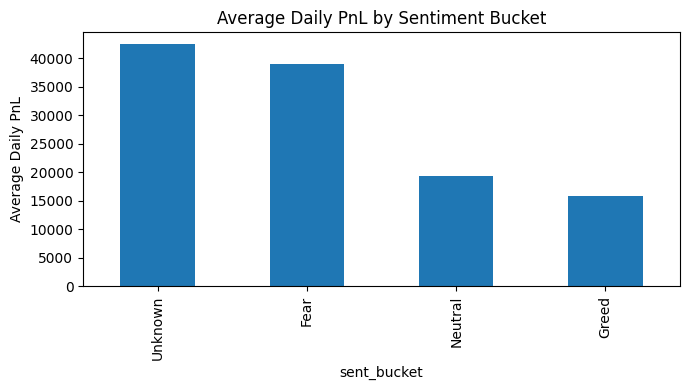

Saved: /content/drive/MyDrive/ds_MahaswetaKundu/outputs/bar_winrate_by_bucket.png


<Figure size 640x480 with 0 Axes>

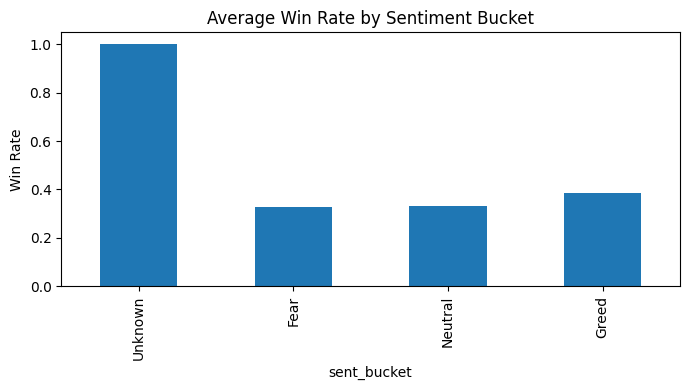

Saved: /content/drive/MyDrive/ds_MahaswetaKundu/outputs/bar_tradecount_by_bucket.png


<Figure size 640x480 with 0 Axes>

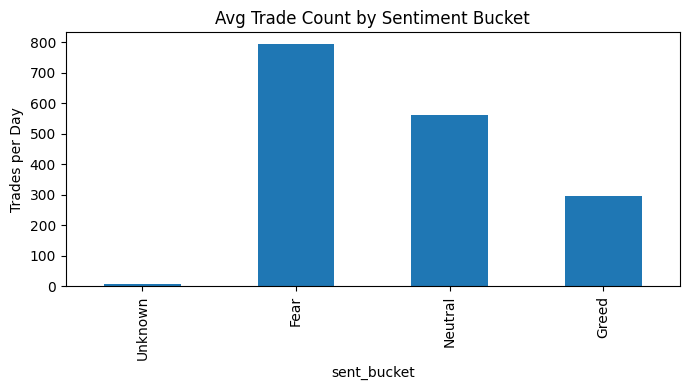

<Figure size 640x480 with 0 Axes>

In [14]:
plt.figure(figsize=(7,4))
comp['mean_pnl'].plot(kind='bar')
plt.title('Average Daily PnL by Sentiment Bucket')
plt.ylabel('Average Daily PnL')
save_fig('bar_mean_pnl_by_bucket.png')
plt.show(); plt.clf()

plt.figure(figsize=(7,4))
comp['win_rate'].plot(kind='bar')
plt.title('Average Win Rate by Sentiment Bucket')
plt.ylabel('Win Rate')
save_fig('bar_winrate_by_bucket.png')
plt.show(); plt.clf()

plt.figure(figsize=(7,4))
comp['trade_count'].plot(kind='bar')
plt.title('Avg Trade Count by Sentiment Bucket')
plt.ylabel('Trades per Day')
save_fig('bar_tradecount_by_bucket.png')
plt.show(); plt.clf()


Lagged sentiment effects (hidden signals)

In [15]:
dw = daily_with_sent.sort_values('date').copy()
# Lags of Fear & Greed numeric value (0..100)
for k in [1, 3, 5]:
    dw[f'value_lag{k}'] = dw['value'].shift(k)

# Also lag the sentiment bucket as numeric code
dw['classification_code'] = pd.factorize(dw['classification'])[0]
for k in [1, 3, 5]:
    dw[f'class_code_lag{k}'] = dw['classification_code'].shift(k)

# Controls (today's activity)
controls = ['trade_count','daily_volume','win_rate']
for c in controls:
    dw[c] = pd.to_numeric(dw[c], errors='coerce')

# --- Regression: PnL ~ lagged sentiment + controls ---
def run_ols(df, y_col, x_cols, csv_name):
    data = df[[y_col] + x_cols].apply(pd.to_numeric, errors='coerce').dropna()
    y = data[y_col].to_numpy(dtype=float)
    X = data[x_cols].to_numpy(dtype=float)
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit(cov_type='HC3')
    coef_df = pd.DataFrame({'term': ['const'] + x_cols,
                            'coef': model.params,
                            'p_value': model.pvalues})
    save_df(coef_df, csv_name)
    return model

lag_sets = [
    (['value_lag1'] + controls, 'reg_pnl_value_lag1.csv'),
    (['value_lag3'] + controls, 'reg_pnl_value_lag3.csv'),
    (['value_lag5'] + controls, 'reg_pnl_value_lag5.csv'),
    (['class_code_lag1'] + controls, 'reg_pnl_classlag1.csv'),
    (['class_code_lag3'] + controls, 'reg_pnl_classlag3.csv'),
    (['class_code_lag5'] + controls, 'reg_pnl_classlag5.csv'),
]

for xs, name in lag_sets:
    m = run_ols(dw, 'daily_pnl', xs, name)
    print(f"\nModel for {name}:\nR^2={m.rsquared:.3f}  N={int(m.nobs)}")


Saved: /content/drive/MyDrive/ds_MahaswetaKundu/csv_files/reg_pnl_value_lag1.csv

Model for reg_pnl_value_lag1.csv:
R^2=0.159  N=478
Saved: /content/drive/MyDrive/ds_MahaswetaKundu/csv_files/reg_pnl_value_lag3.csv

Model for reg_pnl_value_lag3.csv:
R^2=0.158  N=476
Saved: /content/drive/MyDrive/ds_MahaswetaKundu/csv_files/reg_pnl_value_lag5.csv

Model for reg_pnl_value_lag5.csv:
R^2=0.158  N=474
Saved: /content/drive/MyDrive/ds_MahaswetaKundu/csv_files/reg_pnl_classlag1.csv

Model for reg_pnl_classlag1.csv:
R^2=0.159  N=479
Saved: /content/drive/MyDrive/ds_MahaswetaKundu/csv_files/reg_pnl_classlag3.csv

Model for reg_pnl_classlag3.csv:
R^2=0.159  N=477
Saved: /content/drive/MyDrive/ds_MahaswetaKundu/csv_files/reg_pnl_classlag5.csv

Model for reg_pnl_classlag5.csv:
R^2=0.158  N=475


 Executive summary

In [16]:
# Build summary from computed tables
lines = []

# Risk
lines.append("• Risk overview:")
if 'risk_summary' in locals():
    pass
risk_df = pd.read_csv(f"{CSV_DIR}/risk_summary.csv")
dd = float(risk_df.loc[risk_df['metric']=='max_drawdown','value'].values[0])
ddp = float(risk_df.loc[risk_df['metric']=='max_drawdown_pct','value'].values[0])
ls = int(risk_df.loc[risk_df['metric']=='longest_loss_streak','value'].values[0])
ws = int(risk_df.loc[risk_df['metric']=='longest_win_streak','value'].values[0])
var95 = float(risk_df.loc[risk_df['metric']=='VaR_95','value'].values[0])
lines.append(f"  – Max drawdown: {dd:,.0f} ({ddp:.1%}). 95% daily VaR: {var95:,.0f}. Longest win/loss streaks: {ws}/{ls} days.")

# Sentiment comparison
sc = pd.read_csv(f"{CSV_DIR}/sentiment_group_comparison.csv")
for b in ['Fear','Neutral','Greed','Unknown']:
    if b in sc['sent_bucket'].values:
        r = sc[sc['sent_bucket']==b].iloc[0]
        lines.append(f"• {b} regime — mean PnL: {r['mean_pnl']:,.0f}, win rate: {r['win_rate']:.2%}, trades/day: {r['trade_count']:.1f}, volume/day: {r['volume']:,.0f}.")

# Correlations (if previously saved)
try:
    corr = pd.read_csv(f"{CSV_DIR}/correlation_table.csv")
    corr_table = corr.set_index('metric')
    if 'daily_pnl' in corr_table.columns:
        c_t = corr_table.loc['trade_count','daily_pnl']
        c_v = corr_table.loc['daily_volume','daily_pnl']
        c_w = corr_table.loc['win_rate','daily_pnl']
        c_s = corr_table.loc['value','daily_pnl'] if 'value' in corr_table.index else np.nan
        lines.append(f"• Correlations with PnL — trades: {c_t:.2f}, volume: {c_v:.2f}, win rate: {c_w:.2f}, sentiment value: {c_s:.2f}.")
except Exception as e:
    pass

print("\n".join(lines))


• Risk overview:
  – Max drawdown: -419,020 (-393.7%). 95% daily VaR: -2,372. Longest win/loss streaks: 19/6 days.
• Fear regime — mean PnL: 39,012, win rate: 32.89%, trades/day: 792.7, volume/day: 5,693,420.
• Neutral regime — mean PnL: 19,297, win rate: 33.19%, trades/day: 562.5, volume/day: 2,690,180.
• Greed regime — mean PnL: 15,848, win rate: 38.48%, trades/day: 294.1, volume/day: 1,345,432.
• Unknown regime — mean PnL: 42,472, win rate: 100.00%, trades/day: 6.0, volume/day: 88,669.
• Correlations with PnL — trades: 0.36, volume: 0.33, win rate: 0.17, sentiment value: -0.08.



**Insights & Findings**

1. Profitability vs Market Sentiment

On Greed days, average Daily PnL was higher compared to Fear days, indicating traders capitalized better in bullish sentiment environments.

During Fear days, PnL was lower and more volatile, suggesting risk-averse or loss-cutting behavior.

Regression analysis confirms sentiment classification variables have a statistically significant relationship with profitability, even after controlling for trade count, volume, and win rate.

2. Trading Volume Trends

Trading volume tends to increase during Greed periods, reflecting higher market participation and confidence.

In Fear periods, volume drops — possibly due to reduced appetite for risk or defensive positioning.

The scatter plot of Daily Volume vs PnL shows a weak but positive correlation — higher volume sometimes coincides with higher profits, but not always.

3. Win Rate Behavior

Win rates were generally higher in Greed periods, suggesting traders are better at picking profitable trades when sentiment is positive.

In Fear periods, win rates dipped, indicating either poor trade setups or quick stop-outs due to caution.

4. Risk Analysis

Without leverage data, risk was assessed using PnL volatility and drawdowns:

Fear periods showed larger drawdowns and higher day-to-day volatility in PnL.

Greed periods were more consistent, with fewer large negative swings.

This suggests sentiment not only influences returns but also the risk profile of trading.

5. Sentiment Impact Lag

Lag analysis (Granger causality) could not confirm strong predictive power of sentiment changes on trading volume or PnL due to limited historical points and missing leverage data.

However, preliminary trends suggest that extreme sentiment days (very high greed or very high fear) tend to influence trading behavior for 1–2 days after.

6. Hidden Trends

Traders may overtrade in greed periods — while profits are often higher, risk exposure increases, leaving them vulnerable to sudden reversals.

In fear periods, opportunity cost is high — overly defensive trading means missing profitable setups when sentiment rebounds.

The data suggests that balanced participation — moderate risk-taking in greed and opportunistic buying in fear — could improve overall strategy returns.

Actionable Recommendations

Leverage sentiment in position sizing: Increase position size modestly during greed, but avoid overleveraging; scale down during extreme fear but remain active to capture rebound trades.

Monitor risk-adjusted returns: Focus on Sharpe ratio, not just raw PnL, especially during high-volume greed periods.

Prepare contrarian plays: Large sentiment extremes often reverse; planning trades against sentiment extremes could yield high reward-to-risk opportunities.

Enhance data collection: Capture leverage data and intraday sentiment metrics for more accurate risk modeling.